### Reconstruction of simulated nanoparticles using the Deep Image Prior approach

*This notebook presents the reconstruction of simulated nanoparticles using DIP approach. The method is applied on one simulated sinogram, for different scenarios with various numbers of available projections. The sinogram containing 180 projections is also available for comparison. The three acquisition scenarios are:*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

#### The DIP formulation adapted to tomography consists of solving the following problem :

$$ \hat{\theta} = \underset{\theta}{\arg\min} \left\| P F_{\theta}(z) - y \right\|_2^2 $$

Where :
- $ F_{\theta} $ are the network and weights to optimized
- $ P $ is the forward operator (Radon transform)
- $ z $ is an input noise
- $ y $ are the acquired projections

*The method is applied to a 2D sinogram in order to reconstruct a 2D image.*

In [7]:
import sys
sys.path.insert(0, '../../Src')
from model import model_unet
from radon import Radon2D
from dip import dip_reconstruction
from utils import simplify, normalize, to8bit, sinoToFullView

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import torch

dtype = torch.cuda.FloatTensor
plt.rcParams['image.cmap'] = 'gray'

#### Load the simulated nanoparticles image to be reconstructed

The sinograms of interest are stored in *Data/Simulated/Sinograms* and corresponding angular range are placed in *Data/Angles*.
The acquisition scenario can be selected (1, 2 or 3) with **ACQUISITION_CASE**.
Both degraded and reference sinograms are loaded and the corresponding SIRT reconstructions are computed.

In [8]:
# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3
IMG_SIZE = 512


# Degraded sinogram & reconstruction
with open(f'../../Data/Angles/angles_{ACQUISITION_CASE}.txt') as file:
    ANGLE = np.array([int(line.strip()) for line in file])

degraded_sinogram = imread(f'../../Data/Simulated/Sinograms/simulated_{ACQUISITION_CASE}.tif')
degraded_sinogram = torch.from_numpy(degraded_sinogram).type(dtype)

radon_op_degraded = Radon2D(angle=np.deg2rad(ANGLE), size=IMG_SIZE)
sirt_degraded = radon_op_degraded.backward_sirt_ts(degraded_sinogram)
sirt_degraded = normalize(sirt_degraded)


# Reference sinogram & reconstruction
with open(f'../../Data/Angles/angles_reference.txt') as file:
    ANGLE_reference = np.array([int(line.strip()) for line in file])

reference_sinogram = imread(f'../../Data/Simulated/Sinograms/simulated_reference.tif')
reference_sinogram = torch.from_numpy(reference_sinogram).type(dtype)

radon_op_reference = Radon2D(angle=np.deg2rad(ANGLE_reference), size=IMG_SIZE)
sirt_reference = radon_op_reference.backward_sirt_ts(reference_sinogram)
sirt_reference = normalize(sirt_reference)

Text(0.5, 1.0, 'Degraded sinogram (missing projections)')

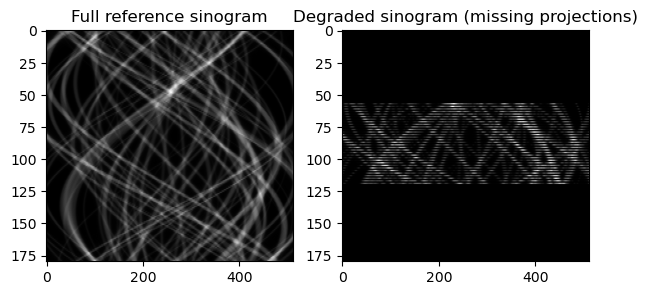

In [9]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize = (7,3))

ax0.imshow((simplify(reference_sinogram)), aspect='auto')
ax0.set_title('Full reference sinogram')
ax1.imshow(sinoToFullView(degraded_sinogram, ANGLE), aspect='auto')
ax1.set_title('Degraded sinogram (missing projections)')

#### Setup of the network and DIP parameters

The parameters are set with the values from the article.

- *NUM_ITER* : Number of training iterations (empirical choice)
- *LR* : optimization learning rate
- *INPUT_DEPTH* : Depth size of the input noise
- *STD_INP_NOISE* : Range of the input noise
- *NOISE_REG* : Per iteration regularization value on the input noise (from original DIP implementation (D. Ulyanov et al.))

For the DIP method :
- A possible TV weight can be added to add a TV regularization (*TV_WEIGHT*)

In [10]:
NUM_ITER = 3000
LR = 0.01
INPUT_DEPTH = 32
STD_INP_NOISE = 1./10. 
NOISE_REG = 1./30.
TV_WEIGHT = 0.0 # Optionnal

In [11]:
n_scale = 4
ud_filters = [16,32,64,128]
skip_filters = [4,8,16,32]
network = model_unet(input_shape=INPUT_DEPTH, output_shape=1,
                     down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
                     down_kernels=[3]*n_scale, up_kernels=[3]*n_scale, skip_kernels=[1]*n_scale,
                     up_mode='bilinear', down_mode='stride', pad_mode='zeros',
                     ).to('cuda').type(dtype)

  0%|          | 0/3000 [00:00<?, ?it/s]

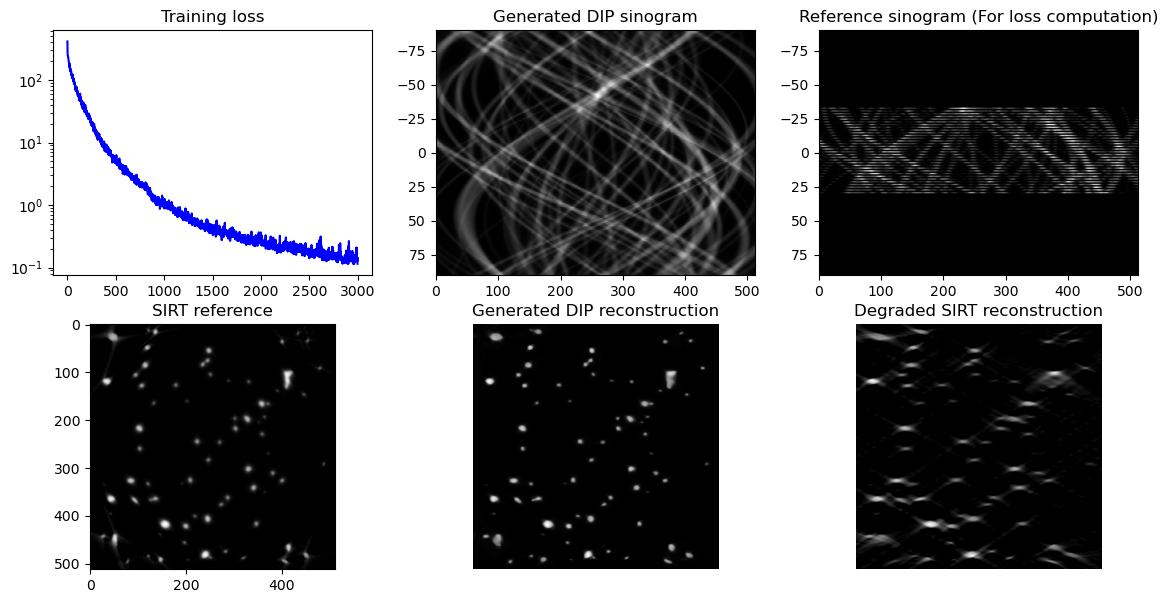

100%|██████████| 3000/3000 [01:22<00:00, 36.57it/s]


In [12]:
output = dip_reconstruction(NUM_ITER, LR, 512, STD_INP_NOISE, NOISE_REG,
                            np.flip(ANGLE), INPUT_DEPTH, network,
                            degraded_sinogram, sirt_degraded, sirt_reference, DISPLAY=True,
                            SHOW_EVERY=100, tv_weight=TV_WEIGHT)

best_loss   = output['best_loss']
best_output = output['best_output']
best_i      = output['best_i']
loss_values = output['loss_values']
net_trained = output['net']
best_input  = output['best_input']

#### Comparison of the results and computation of image quality metrics.

Text(0.5, 1.0, 'reference SIRT reconstruction')

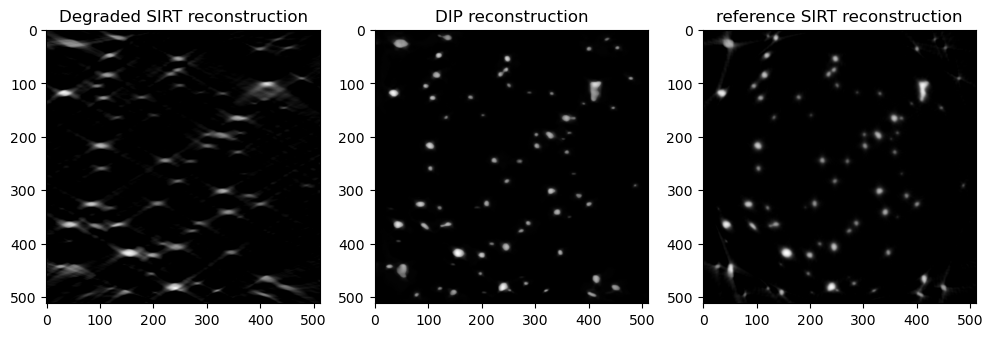

In [13]:
fig, ((ax0, ax1, ax2)) = plt.subplots(1, 3, figsize = (12,8))
ax0.imshow(simplify(sirt_degraded))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(best_output))
ax1.set_title('DIP reconstruction')
ax2.imshow(simplify(sirt_reference))
ax2.set_title('reference SIRT reconstruction')

In [14]:
# Computation of image quality metrics on the SIRT reconstruction and the restored images

ref = to8bit(sirt_reference)
sirt = to8bit(sirt_degraded)
dip = to8bit(best_output)

ssim_sirt = ssim(ref, sirt)
psnr_sirt = psnr(ref, sirt)
ssim_dip = ssim(ref, dip)
psnr_dip = psnr(ref, dip)

print('Degraded SIRT')
print(f'SSIM: {ssim_sirt:.4f} - PSNR: {psnr_sirt:.4f}')
print('Restored')
print(f'SSIM: {ssim_dip:.4f} - PSNR: {psnr_dip:.4f}')

Degraded SIRT
SSIM: 0.6947 - PSNR: 24.1315
Restored
SSIM: 0.9210 - PSNR: 32.9185
